In [1]:
import cv2
import numpy as np
import os
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from matplotlib import pyplot as plt
import matplotlib.path as mplPath
import xml.etree.ElementTree as ET

In [2]:
def plotImage(img, size):
    fig, ax = plt.subplots(figsize=(size,size))
    plt.imshow(img)
    plt.xticks([]),plt.yticks([])
    plt.show()

In [3]:
def subplot(titles, images, rows, imgPerRows, size):
    fig, ax = plt.subplots(figsize=(size,size))
    for i in range(len(images)):
        plt.subplot(rows,imgPerRows,i+1),plt.imshow(images[i])
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()

In [4]:
def resizeImage (image):
    factor = 2**-3
    dim = (int(image.shape[1]*factor),int(image.shape[0]*factor))
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized

In [5]:
def generateCNNInputs(imgList, inputList, numSuperPixels, sizePatch):
    for i in range(len(imgList)):
        img = imgList[i]
        imgCopy = img.copy()
        segments = slic(img,numSuperPixels)
        
        for (j , segVal) in enumerate(np.unique(segments)):

            if segVal == 0:
                continue

            mask = np.zeros(img.shape[:2], dtype = "uint8")
            mask[segments == segVal] = 255
            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
            c = max(cnts, key=cv2.contourArea)
            #saving every single cell as a rectangular image.
            x,y,w,h = cv2.boundingRect(c)
            roi = image[y:y+h, x:x+w]
            xPatch = 0
            yPatch = 0
            
            if roi.shape[0]*roi.shape[1] < sizePatch**2:
                xPatch = x-sizePach/2+w/2
                yPatch = y-siezePatch/2+h/2
            else:
                xPatch = x+sizePach/2-w/2
                yPatch = y+siezePatch/2-h/2
            
            patch = image[yPatch:y+sizePatch, xPatch:x+sizePatch]
            patchGray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
            inputList.append(patchGray)
            

In [6]:
def groundThruthFindCountourPointsByRegion (pathGroundThruthFile, region) :
    listPixels = []
    polygonsByRegion = []
    pointsPolygon = []
    tree = ET.parse(pathGroundThruthFile)
    root = tree.getroot()

    for neighbor in root.iter('TextRegion') :
        
        if (neighbor.attrib['type'] == region) :
            pointsPolygon = []
            
            for coord in neighbor.findall('Coords') :
                
                for point in coord.findall('Point') :
                    pointsPolygon.append([point.attrib['x'], point.attrib['y']])
                    
                polygonsByRegion.append(pointsPolygon)
                
    return polygonsByRegion

In [7]:
def isInsidePolygon (listPointsPolygon, x, y) :
    bbPath = mplPath.Path(listPointsPolygon)
    point = ([x, y])
    return bbPath.contains_point(point)

In [8]:
path = 'groundTruth/d-006_kai.chen@unifr.ch.xml'
#listPoints = groundThruthFindCountourPointsByRegion (path, 'decoration')
#boolean = isInsidePolygon (listPoints, 1123, 936)
#print (boolean)

In [9]:
nameFolder = 'parzivalDataset'
ximg_train = []
ximg_test = []
ximg_va = []
ximg = []
imgOrigs = []

x_train = []
y_train = []
x_test = []
y_test = []
x_va = []
y_va = []
x = []
y = []


In [10]:
for file in os.listdir(nameFolder):
    image = cv2.imread(nameFolder + "/" + file)
    imageResized = resizeImage(image)
    imgOrigs.append(image)
    ximg.append(imageResized)


In [11]:
ximg_train = ximg[:37]
ximg_test = ximg[37:]

print(np.shape(ximg_train))
print(np.shape(ximg_test))

(37, 376, 250, 3)
(10, 376, 250, 3)


In [12]:
imgTr = ximg_train[0]
imgTrainCopy = imgTr.copy()
segments = slic(imgTr,3000)

for (j , segVal) in enumerate(np.unique(segments)):
    
    if segVal == 0:
        continue
        
    mask = np.zeros(imgTr.shape[:2], dtype = "uint8")
    mask[segments == segVal] = 255
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    c = max(cnts, key=cv2.contourArea)
    #saving every single cell as a rectangular image.
    x,y,w,h = cv2.boundingRect(c)
    roi = image[y:y+h, x:x+w]
    cv2.rectangle(imgTrainCopy,(x,y),(x+w,y+h),(0,255,0),2)    


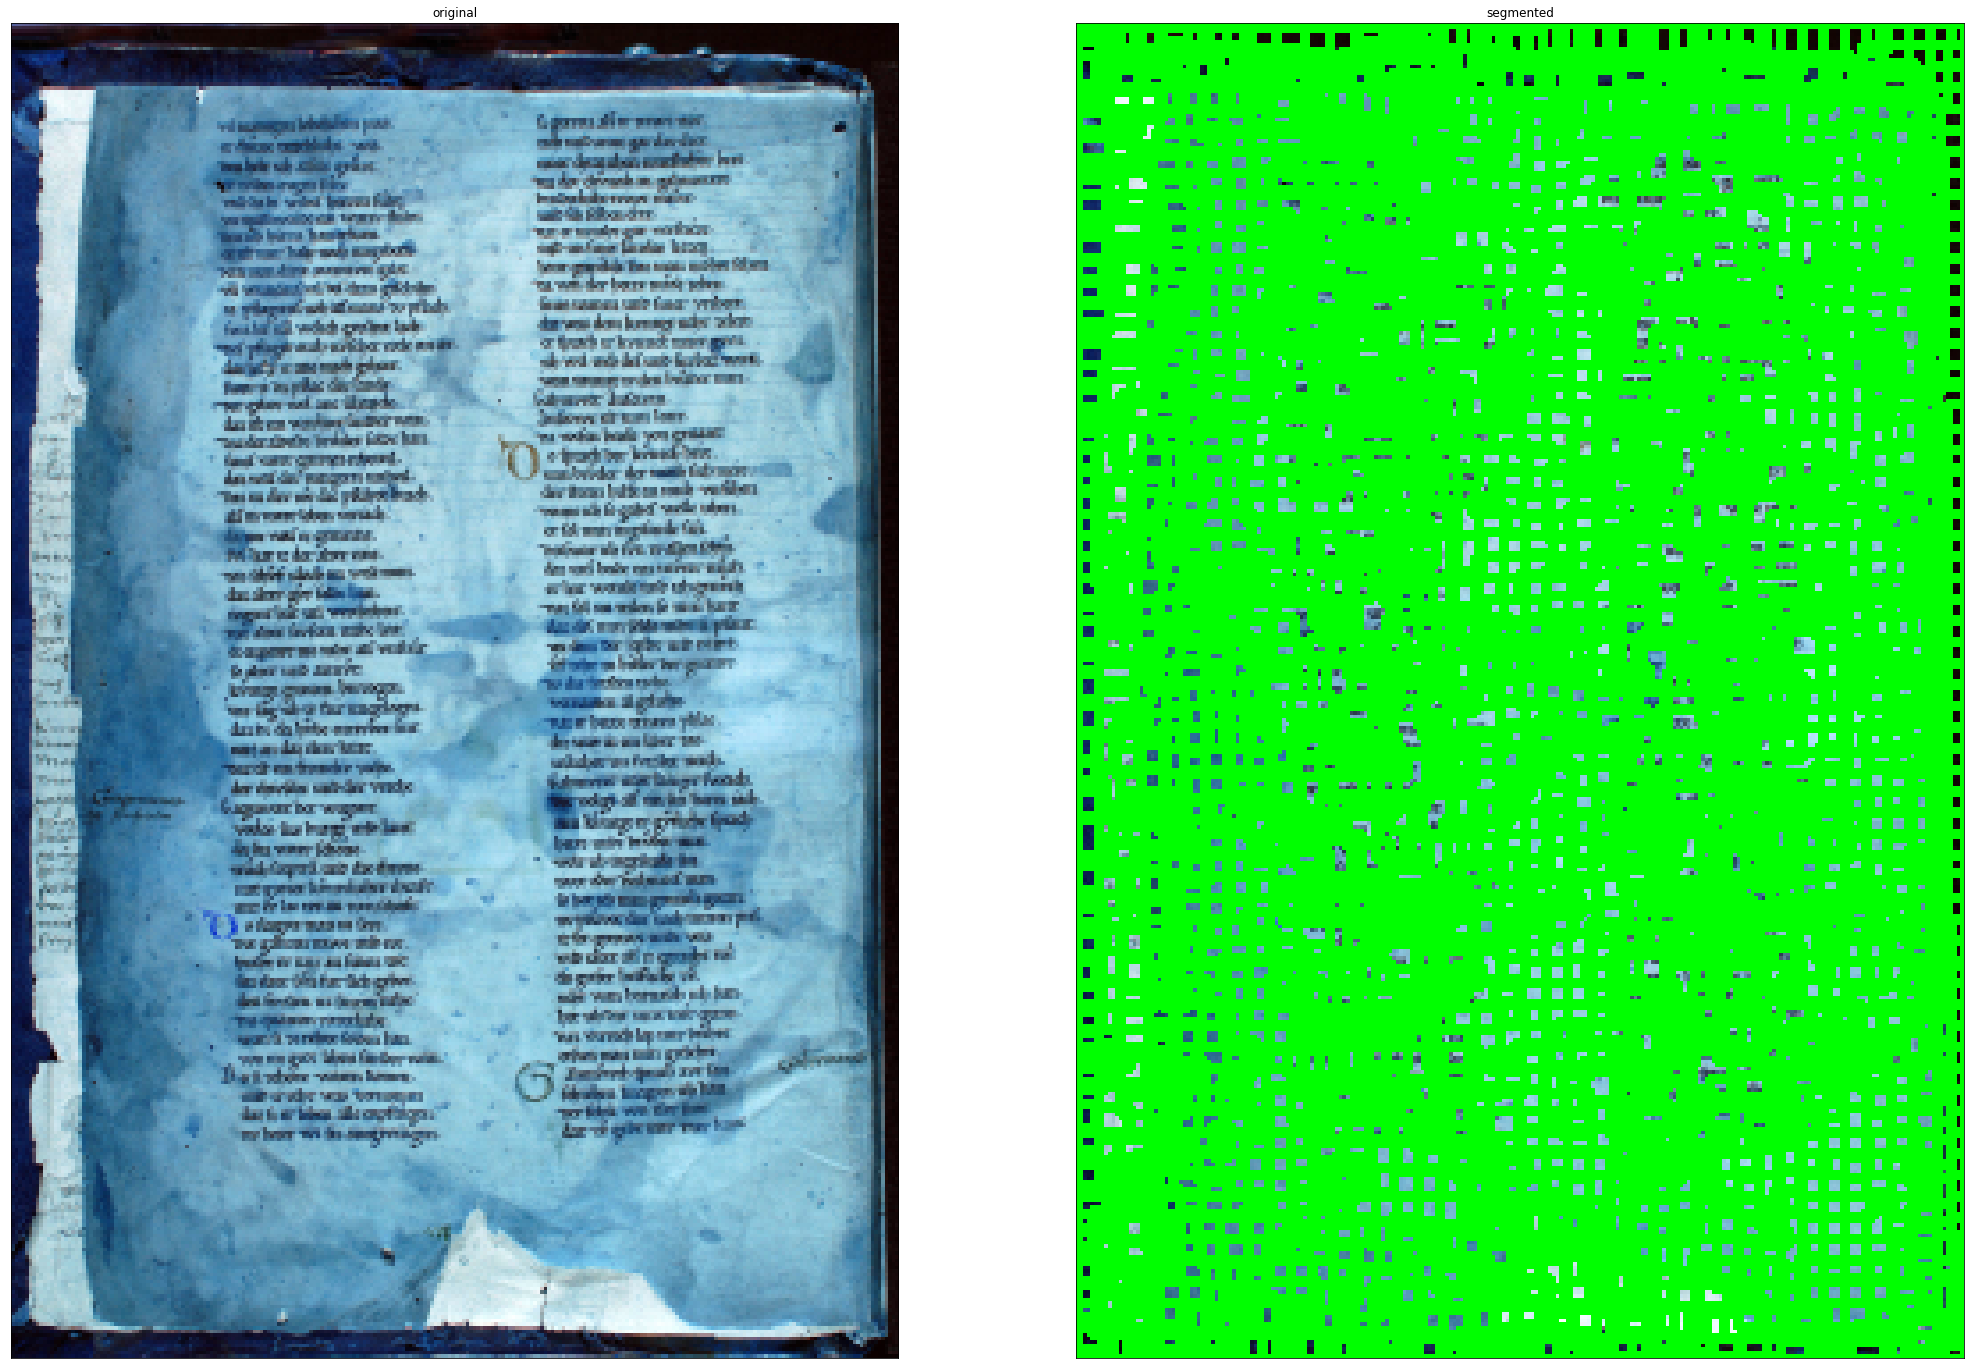

In [13]:
titles = ['original', 'segmented']
images = [imgTr, imgTrainCopy]
subplot(titles, images, 1, 2, 35)

### Printing ground thruth segments on image: 
### Peripheric(outside page), Background(page), text block(text) ,decoration and comment

In [14]:
imgTr
imageWidth = imgTr.shape[1] #Get image width
imageHeight = imgTr.shape[0] #Get image height
print (imageWidth)
print (imageHeight)

250
376


In [15]:
#xPos, yPos = 0, 0
#path = 'groundTruth/d-006_kai.chen@unifr.ch.xml'
#regions = ['page','text','decoration','comment']
#listPoints = groundThruthFindCountourPointsByRegion (path, 'decoration')
#boolean = isInsidePolygon (listPoints, 1123, 936)
#while xPos < imageWidth: #Loop through rows
#    while yPos < imageHeight: #Loop through collumns
#        for k in range(len(regions)) :
#            listPointPolygonRegion = groundThruthFindCountourPointsByRegion(path,regions[k])
#            if regions[k] == 'text':
#                if isInsidePolygon (listPointPolygonRegion, xPos*2**3, yPos*2**3) :
#                    imgTr.itemset((yPos, xPos, 0), 0) #Set B to 255
#                    imgTr.itemset((yPos, xPos, 1), 0) #Set G to 255
#                    imgTr.itemset((yPos, xPos, 2), 255) #Set R to 255
#        yPos = yPos + 1 #Increment Y position by 1

#    yPos = 0
#    xPos = xPos + 1 #Increment X position by 1



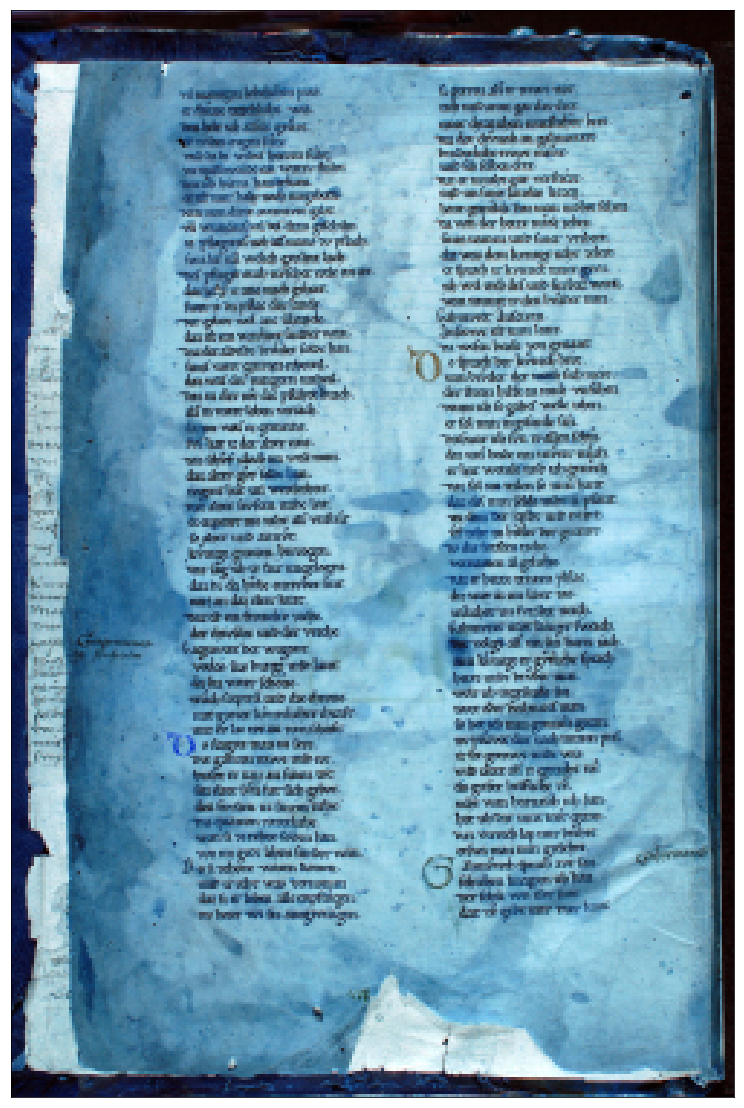

In [16]:
plotImage (imgTr,20)

In [17]:
xPos, yPos = 0, 0
path = 'groundTruth/d-006_kai.chen@unifr.ch.xml'
regions = ['page','text','decoration','comment']
#listPoints = groundThruthFindCountourPointsByRegion (path, 'decoration')
#boolean = isInsidePolygon (listPoints, 1123, 936)
while xPos < imageWidth: #Loop through rows
    while yPos < imageHeight: #Loop through collumns
        for k in range(len(regions)) :
            listPolygons = groundThruthFindCountourPointsByRegion(path,regions[k])
            for t in range(len(listPolygons)) :
                listPointPolygonRegion = listPolygons[t]
                if regions[k] == 'decoration':
                    if isInsidePolygon (listPointPolygonRegion, xPos*2**3, yPos*2**3) :
                        imgTr.itemset((yPos, xPos, 0), 0) #Set B to 255
                        imgTr.itemset((yPos, xPos, 1), 255) #Set G to 255
                        imgTr.itemset((yPos, xPos, 2), 0) #Set R to 255
        yPos = yPos + 1 #Increment Y position by 1

    yPos = 0
    xPos = xPos + 1 #Increment X position by 1

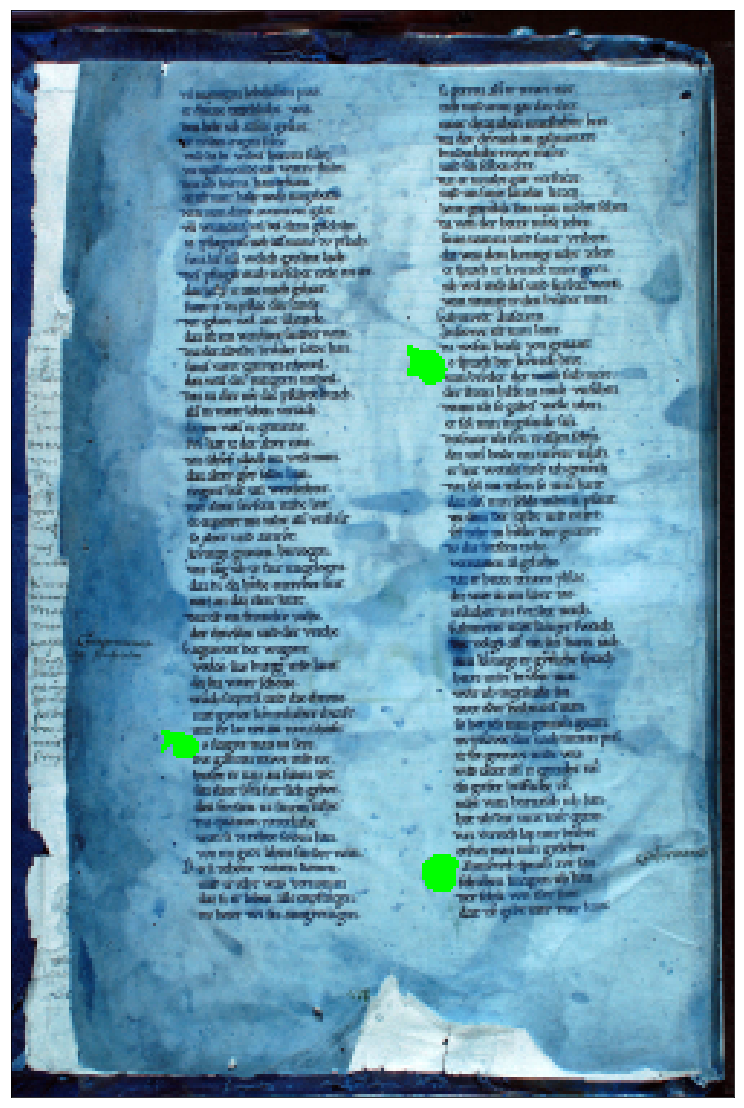

In [18]:
plotImage (imgTr,20)